In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
import cmocean

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import geopandas as gpd
import pandas as pd

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.models.pca import PCA_AE
from src.inputs import GaussianInputs
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [3]:
states = gpd.read_file(f'{project_root}/data/massachusetts/s_08mr23.shp')
mass = states[states['NAME']=='Massachusetts']

In [ ]:
project = 'fvcom'
tstep = 11129

t = np.load(f'{project_root}/data/{project}/t.npy')
reference_date = pd.Timestamp("2005-01-01")
datetimes = [reference_date + pd.to_timedelta(days - 732313.0, unit='D') for days in t]
datetimes_np = np.array(datetimes, dtype='datetime64[ns]')


# Find tstep where datetimes_np is July 9th, 2011
# target_date = np.datetime64('2010-07-09')
target_date = pd.Timestamp('2010-07-09T16:00:00Z')
tstep = np.argmin(np.abs(datetimes_np - np.datetime64(target_date)))


date_print = target_date.strftime('%Y-%m-%d')
date_save = target_date.strftime('%Y-%m-%d-%H')+'h'

print(date_print)
print(datetimes_np[tstep])
print(tstep)

07-09-10
['2010-07-09T18:00:00.000000000']
9620


In [5]:
xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

grid_x = np.load(f'{project_root}/data/{project}/grid_x.npy')
grid_y = np.load(f'{project_root}/data/{project}/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

u = np.load(f'{project_root}/data/{project}/u_interp.npy') 
v = np.load(f'{project_root}/data/{project}/v_interp.npy')
nt, n1, n2 = u.shape
mask = np.isnan(u[0,:,:])

u_fill, v_fill = u.copy(), v.copy()
u_fill[:, mask] = 0
v_fill[:, mask] = 0

In [6]:
seed = 0
np.random.seed(seed)

safe_mask = binary_erosion(~mask, structure=np.ones((15, 15)))  
yy, xx = np.where(safe_mask)
coords = np.array(list(zip(xx, yy)))

x0, y0 = -70.439467, 42.302897 # drifter release
dist_sq = (grid_x - x0)**2 + (grid_y - y0)**2
coords_0 = np.unravel_index(np.argmin(dist_sq), dist_sq.shape)

dt = 3600
ndays = 0.75
T = ndays*24*60*60
dts = [dt for _ in range(int(T / dt))]

num_traj = 5
selected = [coords[np.random.randint(len(coords))]]  # start with random point
# selected = [coords_0]  # start with drifter release point
for _ in range(num_traj - 1):
    dists = cdist(coords, np.array(selected))
    min_dists = dists.min(axis=1)
    next_idx = np.argmax(min_dists)
    selected.append(coords[next_idx])
selected = np.array(selected)

trajectories_m = {}
trajectories = {}

for traj_i in range(num_traj):
    x0_i = grid_x_m[selected[traj_i, 1], selected[traj_i, 0]]
    y0_i = grid_y_m[selected[traj_i, 1], selected[traj_i, 0]]

    traj_m = generate_trajectory(u_fill[tstep, :, :], v_fill[tstep, :, :], grid_x_m, grid_y_m, x0_i, y0_i, dts)
    trajectories_m[traj_i] = traj_m
    traj = np.array(sp_proj('inverse', traj_m[:,0], traj_m[:,1], 'm')).T
    trajectories[traj_i] = traj


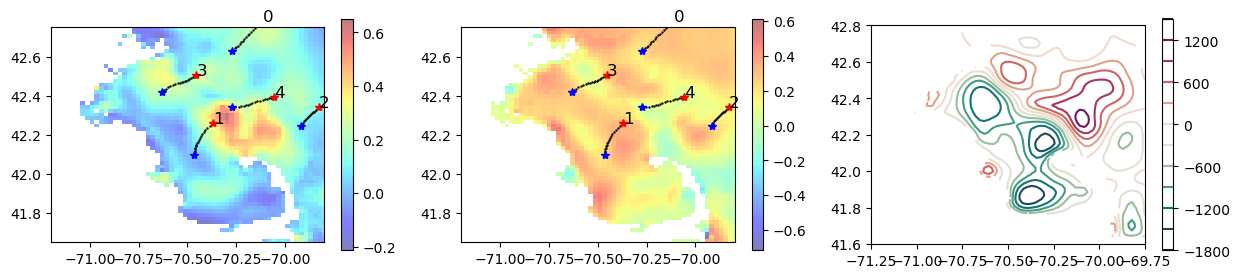

In [7]:
plt.figure(figsize=(15,3))

for i in range(3):
    if i == 0:
        plot_data = u[tstep,:,:]
    elif i == 1:
        plot_data = v[tstep,:,:]
    elif i == 2:
        plot_omega = vort_FVCOM(u[tstep,:,:], v[tstep,:,:], grid_x_m, grid_y_m) #s^-1
        plot_data = streamfunction_FVCOM(plot_omega, grid_x_m, grid_y_m) # m^2/s
        
    ax = plt.subplot(1,3,i+1)
    if i  == 0 or i == 1:
        c = plot_trajectories(ax, plot_data, grid_x, grid_y, trajectories, xmin, xmax, ymin, ymax, cmap='jet')
        for traj_i in range(num_traj):
            plt.text(trajectories[traj_i][-1, 0], trajectories[traj_i][-1, 1], str(traj_i), fontsize=12, color='black')
    else:
        c = plt.contour(grid_x, grid_y, plot_data, levels=10, cmap=cmocean.cm.curl)
        ax.set_aspect('equal', adjustable='box')
    plt.colorbar(c)

In [21]:
latent_dim = 20
data, ae_scaler = transform_data_for_AE(u,v)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ae = CNN_AE(latent_dim=latent_dim)
ae.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
ae.to(device)
latent_space = get_latent_space(ae, data)

# device = 'cpu'
# ae = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
# latent_space = ae.encode(data).T

D = ae.decode

latent_distribution = gaussian_kde(latent_space)

In [22]:
acquisition_function = 'LCB'
optimizer = DeepGPOptimizer(trajectories_m, dts, trajectory_cost_function, D, latent_distribution, grid_x_m, grid_y_m, ae_scaler, device, acquisition_function, mask)
# optimizer = GPOptimizer(trajectories_m, dts, trajectory_cost_function, D, latent_distribution, grid_x_m, grid_y_m, ae_scaler, device, acquisition_function, mask)

In [23]:
try:
    optimizer.optimize(n_iterations=150)
except Exception as e:
    print(f"Optimization failed with error: {e}")

Iteration 0: 382614.99263229984
Iteration 1: 231086.6937411353
Iteration 6: 211574.12694913498
Iteration 7: 125798.51096431976
Iteration 12: 104438.29292290438
Iteration 120: 102300.91398935445
Iteration 149: 81893.8426407863


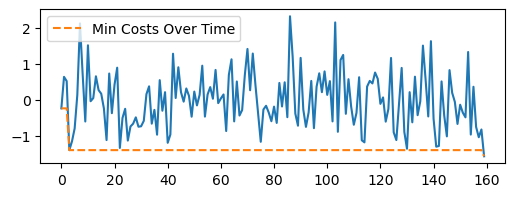

In [24]:
costs = optimizer.Y
min_costs_over_time = [np.min(costs[:i+1]) for i in range(len(costs))]
plt.figure(figsize=(6,2))
plt.plot(costs)
plt.plot(min_costs_over_time, label='Min Costs Over Time', linestyle='--')
plt.legend()

In [25]:
z_opt, u_opt, v_opt, traj_opt_m = optimizer.get_optimal()

traj_opt = {}
for traj_i in range(num_traj):
    traj_opt[traj_i] = np.array(sp_proj('inverse', traj_opt_m[traj_i][:,0], traj_opt_m[traj_i][:,1], 'm')).T


In [26]:
u_plot = u[tstep, :, :]
v_plot = v[tstep, :, :]

w_plot = vort_FVCOM(u_plot, v_plot, grid_x_m, grid_y_m)
psi_plot = streamfunction_FVCOM(w_plot, grid_x_m, grid_y_m)

w_opt = vort_FVCOM(u_opt, v_opt, grid_x_m, grid_y_m)
psi_opt = streamfunction_FVCOM(w_opt, grid_x_m, grid_y_m)

costs = optimizer.Y
costs = optimizer.scaler_gp_y.inverse_transform(costs.reshape(-1, 1)).reshape(-1)
costs_sorted = np.sort(costs)

# k = len(np.argwhere(costs - costs_sorted[0] < 0.5))
k=5
z_top, u_top, v_top, traj_top_m = optimizer.get_top_k(k)
traj_top = []
for traj_k in range(k):
    traj_top.append({})
    for traj_i in range(num_traj):
        traj_top[traj_k][traj_i] = np.array(sp_proj('inverse', traj_top_m[traj_k][traj_i][:,0], traj_top_m[traj_k][traj_i][:,1], 'm')).T

w_top = np.array([vort_FVCOM(ui, vi, grid_x_m, grid_y_m) for ui, vi in zip(u_top, v_top)])
psi_top = np.array([streamfunction_FVCOM(wi, grid_x_m, grid_y_m) for wi in w_top])

u_mean = np.mean(np.array(u_top), axis=0)
v_mean = np.mean(np.array(v_top), axis=0)
w_mean = np.mean(np.array(w_top), axis=0)
psi_mean = np.mean(np.array(psi_top), axis=0)

w_plot = w_plot*1e5
w_opt = w_opt*1e5
w_mean = w_mean*1e5
w_top = w_top*1e5

use_km = False
if use_km:
    psi_plot = psi_plot/1e6
    psi_opt = psi_opt/1e6
    psi_mean = psi_mean/1e6
    psi_top = psi_top/1e6
    units = 'km$^2$/s'
else:
    units = 'm$^2$/s'


In [27]:
vmin_u, vmax_u = -0.25, 0.25
vmin_v, vmax_v = -0.6, 0.6
vmin_psi, vmax_psi = np.nanmin(psi_plot), np.nanmax(psi_plot)
psi_err_lim = 0.5*np.max(np.abs([vmin_psi, vmax_psi]))

vmin_vort, vmax_vort = 0.1*np.nanmin(w_plot), 0.1*np.nanmax(w_plot)
vort_err_lim = 0.7*np.max(np.abs([vmin_vort, vmax_vort]))

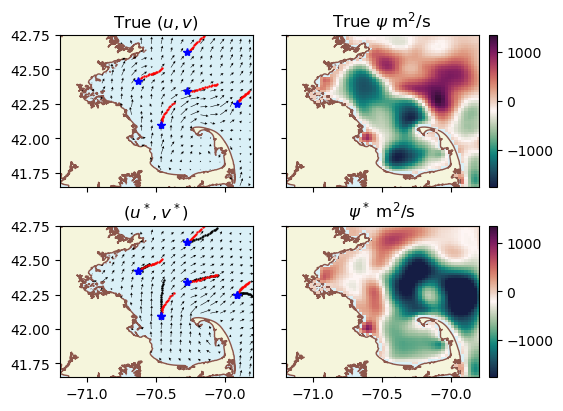

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(5.5, 4), constrained_layout=True, sharex=True, sharey=True)

for row in axes:
    for ax in row:
        ax.set_facecolor(np.array([218, 240, 247])/255)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_aspect('equal', adjustable='box')

# Plot true quiver
axes[0,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_plot[::3, ::3], v_plot[::3, ::3], color='k', headwidth=5)
axes[0,0].set_title('True $(u, v)$')
plt.subplot(2,2,1)
plot_trajectories_lines(trajectories, color='red')

# Plot mean quiver
axes[1,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_mean[::3, ::3], v_mean[::3, ::3], color='k', headwidth=5)
plt.subplot(2,2,3)
plot_trajectories_lines(traj_opt, color='black')
plot_trajectories_lines(trajectories, color='red')
axes[1,0].set_title('$(u^*, v^*)$')

# Plot true psi
c1 = axes[0,1].pcolormesh(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
axes[0,1].set_title('True $\psi$ ' + units)
plt.colorbar(c1, ax=axes[0,1])

# Plot mean psi
c2 = axes[1,1].pcolormesh(grid_x, grid_y, psi_opt, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
axes[1,1].set_title('$\psi^*$ ' + units)
plt.colorbar(c2, ax=axes[1,1])



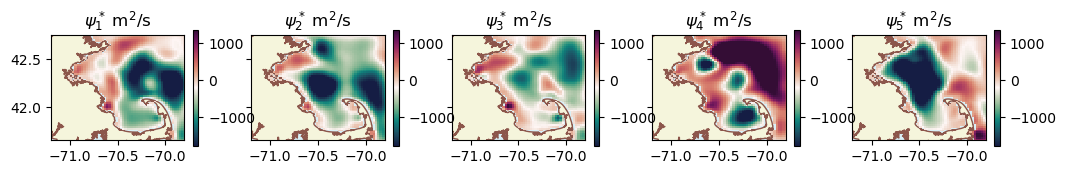

In [29]:
fig, axes = plt.subplots(1, k, figsize=(2.5* k, 1.5), sharex=True, sharey=True)

for idx in range(k):
    ax = axes[idx] if k > 1 else axes
    ax.set_facecolor(np.array([218, 240, 247])/255)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')
    c = ax.pcolormesh(grid_x, grid_y, psi_top[idx], cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
    ax.set_title(f'$\psi^*_{idx+1}$ ' + units)
    plt.colorbar(c, ax=ax)

plt.savefig(f'{project_root}/figures/{project}/bo/top{k}_psi_{latent_dim}_idx_{date_print}.png', dpi=300, bbox_inches='tight')


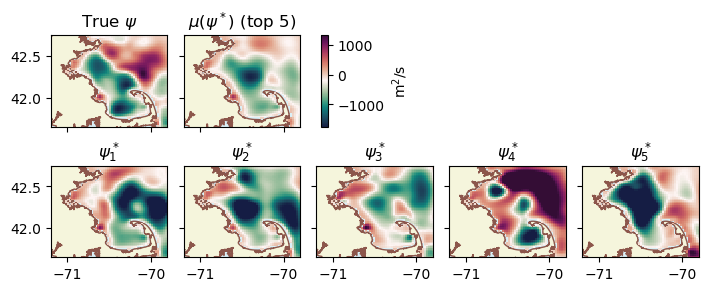

In [30]:
fig, axes = plt.subplots(2, 5, figsize=(7, 2.8), sharex=True, sharey=True, constrained_layout=True)

for i in range(2):
    axes[0, i].set_facecolor(np.array([218, 240, 247])/255)
    axes[0, i].set_xlim(xmin, xmax)
    axes[0, i].set_ylim(ymin, ymax)
    mass.plot(ax=axes[0, i], color='beige', edgecolor='tab:brown')
    axes[0, i].set_aspect('equal', adjustable='box')

c_true = axes[0, 0].pcolormesh(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
axes[0, 0].set_title('True $\psi$')

c_mean = axes[0, 1].pcolormesh(grid_x, grid_y, psi_mean, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
axes[0, 1].set_title('$\mu(\psi^*)$ (top {})'.format(k))

for idx in range(5):
    ax = axes[1, idx]
    ax.set_facecolor(np.array([218, 240, 247])/255)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')
    pcm = ax.pcolormesh(grid_x, grid_y, psi_top[idx], cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
    ax.set_title(f'$\psi^*_{idx+1}$')

axes[0, 2].axis('off')
axes[0, 3].axis('off')
axes[0, 4].axis('off')


# Add a colorbar for c_mean, but do not change subplot spacing
cbar_ax = fig.add_axes([0.45, 0.565, 0.01, 0.33])  # [left, bottom, width, height]
cbar = fig.colorbar(c_mean, cax=cbar_ax, orientation='vertical')
cbar.set_label(units)

# plt.tight_layout()
plt.savefig(f'{project_root}/figures/{project}/bo/top_{k}_psi_{latent_dim}_idx_{date_print}_split.png', dpi=300, bbox_inches='tight')


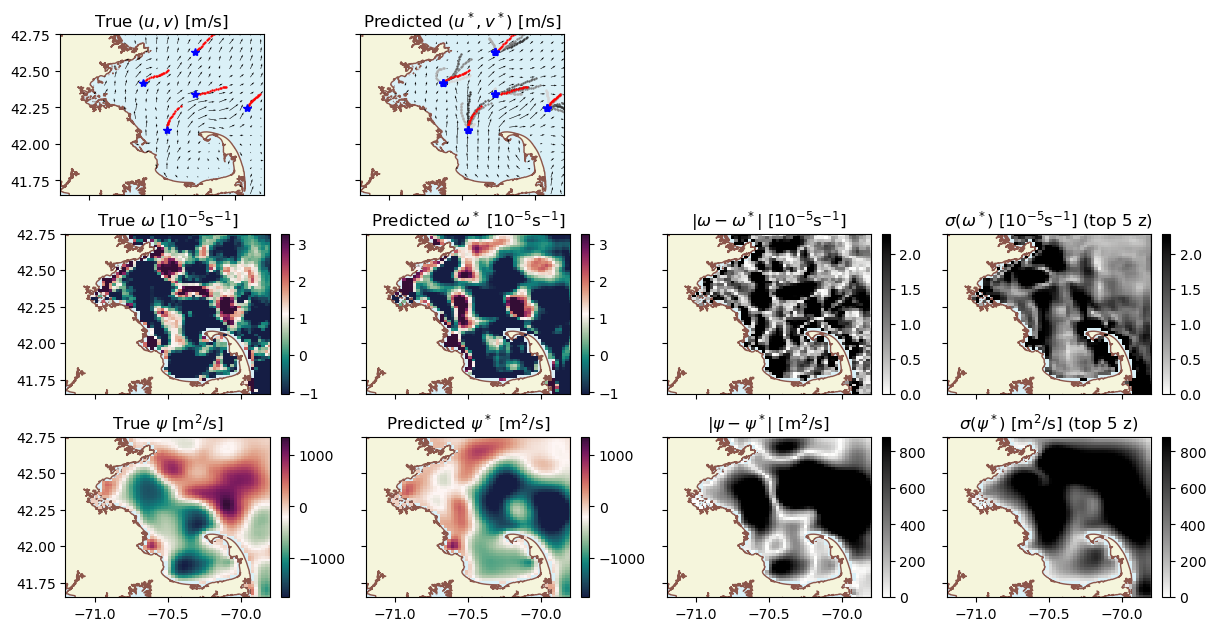

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(12, 6.2), sharex=True, sharey=True, constrained_layout=True)
bg_color = np.array([218, 240, 247]) / 255
cb_shrink=1
def setup_ax(ax):
    ax.set_facecolor(bg_color)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')

# Row 1: (u, v)
setup_ax(axes[0, 0])
axes[0, 0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_plot[::3, ::3], v_plot[::3, ::3], color='k')
plt.sca(axes[0, 0])
plot_trajectories_lines(trajectories, color='red')
axes[0, 0].set_title('True $(u, v)$ [m/s]')

setup_ax(axes[0, 1])
axes[0, 1].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_opt[::3, ::3], v_opt[::3, ::3], color='k')
plt.sca(axes[0, 1])
for j, traj in enumerate(traj_top):
    plot_trajectories_lines(traj, color=str(0.2 + 0.16 * j))
plot_trajectories_lines(trajectories, color='red')
axes[0, 1].set_title('Predicted $(u^*, v^*)$ [m/s]')

# Row 2: omega
setup_ax(axes[1, 0])
c2 = axes[1, 0].pcolormesh(grid_x, grid_y, w_plot, cmap=cmocean.cm.curl, vmin=vmin_vort, vmax=vmax_vort)
plt.colorbar(c2, ax=axes[1, 0], shrink=cb_shrink)
axes[1, 0].set_title('True $\omega$ [10$^{-5}$s$^{-1}$]')

setup_ax(axes[1, 1])
c5 = axes[1, 1].pcolormesh(grid_x, grid_y, w_opt, cmap=cmocean.cm.curl, vmin=vmin_vort, vmax=vmax_vort)
plt.colorbar(c5, ax=axes[1, 1], shrink=cb_shrink)
axes[1, 1].set_title('Predicted $\omega^*$ [10$^{-5}$s$^{-1}$]')

setup_ax(axes[1, 2])
c7 = axes[1, 2].pcolormesh(grid_x, grid_y, np.abs(w_plot - w_opt), cmap=cmocean.cm.gray_r, vmin=0, vmax=vort_err_lim)
plt.colorbar(c7, ax=axes[1, 2], shrink=cb_shrink)
# axes[1, 2].set_title('$|\omega - \omega^*|$' + '\n' + 'RMSE: {:.2f} $10^{{-5}}$s$^{{-1}}$'.format(np.sqrt(np.nanmean((w_plot - w_opt)**2))))
axes[1, 2].set_title('$|\omega - \omega^*|$ [10$^{-5}$s$^{-1}$]')

# Row 3: psi
setup_ax(axes[2, 0])
# c3 = axes[2, 0].contour(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl, levels=10, vmin=vmin_psi, vmax=vmax_psi)
c3 = axes[2, 0].pcolormesh(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
cb_true = plt.colorbar(c3, ax=axes[2, 0], shrink=cb_shrink)
axes[2, 0].set_title('True $\psi$ [' + units + ']')

setup_ax(axes[2, 1])
# c6 = axes[2, 1].contour(grid_x, grid_y, psi_opt, cmap=cmocean.cm.curl, levels=10, vmin=vmin_psi, vmax=vmax_psi)
c6 = axes[2, 1].pcolormesh(grid_x, grid_y, psi_opt, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
cb_opt = plt.colorbar(c6, ax=axes[2, 1], shrink=cb_shrink)
axes[2, 1].set_title('Predicted $\psi^*$ [' + units + ']')


setup_ax(axes[2, 2])
c8 = axes[2, 2].pcolormesh(grid_x, grid_y, np.abs(psi_plot - psi_opt), cmap=cmocean.cm.gray_r, vmin=0, vmax=psi_err_lim)
plt.colorbar(c8, ax=axes[2, 2], shrink=cb_shrink)
# axes[2, 2].set_title('$|\psi - \psi^*|$\nRMSE: {:.4f} {}'.format(np.sqrt(np.nanmean((psi_plot - psi_opt)**2)), units))
axes[2, 2].set_title('$|\psi - \psi^*|$ [' + units + ']')

# Row 4: uncertainty
setup_ax(axes[1, 3])
c9 = axes[1, 3].pcolormesh(grid_x, grid_y, np.std(np.array(w_top), axis=0), cmap=cmocean.cm.gray_r, vmin=0, vmax=vort_err_lim)
plt.colorbar(c9, ax=axes[1, 3], shrink=cb_shrink)
axes[1, 3].set_title('$\sigma(\omega^*)$ [10$^{-5}$s$^{-1}$]' + f' (top {k} z)')

setup_ax(axes[2, 3])
c10 = axes[2, 3].pcolormesh(grid_x, grid_y, np.std(np.array(psi_top), axis=0), cmap=cmocean.cm.gray_r, vmin=0, vmax=psi_err_lim)
plt.colorbar(c10, ax=axes[2, 3], shrink=cb_shrink)
axes[2, 3].set_title('$\sigma(\psi^*)$ [' + units + f'] (top {k} z)')

# Hide unused axes in the top row for better alignment
for ax in [axes[0, 2], axes[0, 3]]:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
fig.align_ylabels(axes)

plt.savefig(f'{project_root}/figures/{project}/bo/top{k}_fvcom_optimization_{latent_dim}_idx_{date_print}.png', dpi=300, bbox_inches='tight')



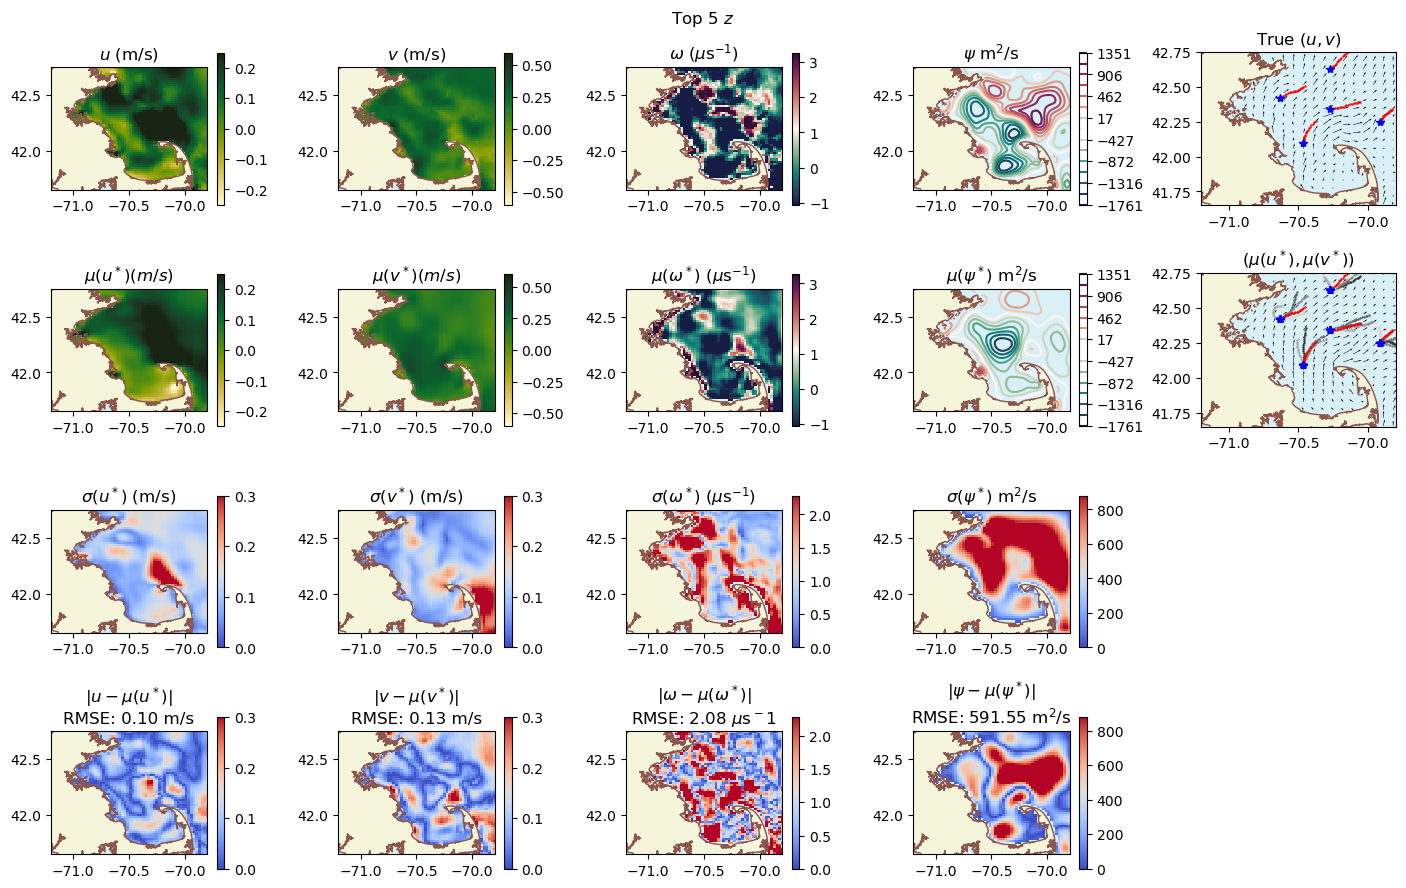

In [32]:
fig = plt.figure(figsize=(14, 9))

# Define configurations for each case
configurations = {
    0: {'plot_data': u_plot, 'cmap': cmocean.cm.speed, 'vmin': vmin_u, 'vmax': vmax_u, 'ttl': '$u$ (m/s)'},
    1: {'plot_data': v_plot, 'cmap': cmocean.cm.speed, 'vmin': vmin_v, 'vmax': vmax_v, 'ttl': '$v$ (m/s)'},
    2: {'plot_data': w_plot, 'cmap': cmocean.cm.curl, 'vmin': vmin_vort, 'vmax': vmax_vort, 'ttl': '$\omega$ ($\mu$s$^{-1}$)'},
    3: {'plot_data': psi_plot, 'cmap': cmocean.cm.curl, 'vmin': vmin_psi, 'vmax': vmax_psi, 'ttl': '$\psi$ ' + units},
    4: {'ttl': 'True $(u,v)$'},
    5: {'plot_data': u_mean, 'cmap': cmocean.cm.speed, 'vmin': vmin_u, 'vmax': vmax_u, 'ttl': '$\mu(u^*) (m/s)$'},
    6: {'plot_data': v_mean, 'cmap': cmocean.cm.speed, 'vmin': vmin_v, 'vmax': vmax_v, 'ttl': '$\mu(v^*) (m/s)$'},
    7: {'plot_data': w_mean , 'cmap': cmocean.cm.curl, 'vmin': vmin_vort, 'vmax': vmax_vort, 'ttl': '$\mu(\omega^*)$ ($\mu$s$^{-1}$)'},
    8: {'plot_data': psi_mean, 'cmap': cmocean.cm.curl, 'vmin': vmin_psi, 'vmax': vmax_psi, 'ttl': '$\mu(\psi^*)$ ' + units},
    9: {'ttl': '$(\mu(u^*),\mu(v^*))$'},
    10: {'plot_data': np.std(np.array(u_top), axis=0), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '$\sigma(u^*)$ (m/s)'},
    11: {'plot_data': np.std(np.array(v_top), axis=0), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '$\sigma(v^*)$ (m/s)'},
    12: {'plot_data': np.std(np.array(w_top), axis=0) , 'cmap': 'coolwarm', 'vmin': 0, 'vmax': vort_err_lim, 'ttl': '$\sigma(\omega^*)$ ($\mu$s$^{-1}$)'},
    13: {'plot_data': np.std(np.array(psi_top), axis=0), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': psi_err_lim, 'ttl': '$\sigma(\psi^*)$ ' + units},
    15: {'plot_data': np.abs(u_plot - u_mean), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '|$u - \mu(u^*)|$\nRMSE: {:.2f} m/s'.format(np.sqrt(np.nanmean((u_plot - u_mean)**2)))},
    16: {'plot_data': np.abs(v_plot - v_mean), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '$|v - \mu(v^*)|$\nRMSE: {:.2f} m/s'.format(np.sqrt(np.nanmean((v_plot - v_mean)**2)))},
    17: {'plot_data': np.abs((w_plot - w_mean)), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': vort_err_lim, 'ttl': f'$|\omega - \mu(\omega^*)|$\nRMSE: {np.sqrt(np.nanmean((w_plot - w_mean)**2)):.2f} $\mu$s$^{-1}$'},
    18: {'plot_data': np.abs(psi_plot - psi_mean), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': psi_err_lim, 'ttl': '$|\psi - \mu(\psi^*)|$\nRMSE: {:.2f} {}'.format(np.sqrt(np.nanmean((psi_plot - psi_mean)**2)), units)}
}

for i in range(20):
    if i in [14, 19]:
        continue

    ax = plt.subplot(4, 5, i + 1)
    ax.set_facecolor(np.array([218, 240, 247])/255)

    if i in configurations:
        config = configurations[i]
        if i in [4, 9]:
            if i == 4:
                plt.quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_plot[::3, ::3], v_plot[::3, ::3], color='k')
                plot_trajectories_lines(trajectories, color='red')
            elif i == 9:
                plt.quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_mean[::3, ::3], v_mean[::3, ::3], color='k')
                for j, traj in enumerate(traj_top):
                    plot_trajectories_lines(traj, color=str(0.2 + 0.16 * j))
                plot_trajectories_lines(trajectories, color='red')
        elif i in [3, 8]:
            levels = np.linspace(config['vmin'], config['vmax'], 15)
            c = plt.contour(grid_x, grid_y, config['plot_data'], levels=levels, cmap=config['cmap'], vmin=config['vmin'], vmax=config['vmax'])
            plt.colorbar(c, shrink=0.9)
        else:
            c = plt.pcolormesh(grid_x, grid_y, config['plot_data'], cmap=config['cmap'], vmin=config['vmin'], vmax=config['vmax'])
            plt.colorbar(c, shrink=0.9)
        plt.title(config['ttl'])

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')

plt.suptitle(f'Top {k} $z$')
plt.tight_layout(pad=0.5)
# plt.savefig(f'{FVCOM_Figures}/FVCOM_optimization_{tstep}_top{k}_uncertainty_{latent_dim}_{acquisition_function}.png', dpi=300, bbox_inches='tight')


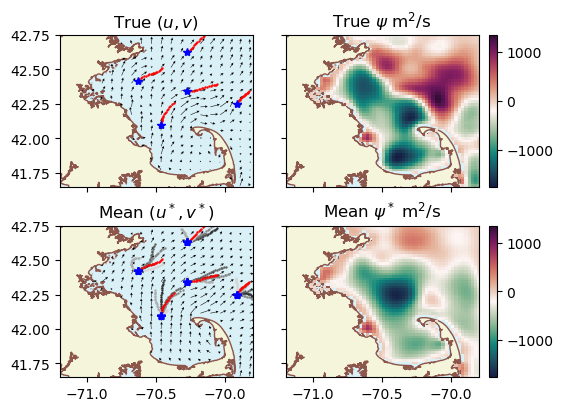

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(5.5, 4), constrained_layout=True, sharex=True, sharey=True)

for row in axes:
    for ax in row:
        ax.set_facecolor(np.array([218, 240, 247])/255)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_aspect('equal', adjustable='box')

# Plot true quiver
axes[0,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_plot[::3, ::3], v_plot[::3, ::3], color='k', headwidth=5)
axes[0,0].set_title('True $(u, v)$')
plt.subplot(2,2,1)
plot_trajectories_lines(trajectories, color='red')

# Plot mean quiver
axes[1,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_mean[::3, ::3], v_mean[::3, ::3], color='k', headwidth=5)
plt.subplot(2,2,3)
for j, traj in enumerate(traj_top):
    plot_trajectories_lines(traj, color=str(0.2 + 0.16 * j))
plot_trajectories_lines(trajectories, color='red')
axes[1,0].set_title('Mean $(u^*, v^*)$')

# Plot true psi
c1 = axes[0,1].pcolormesh(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
axes[0,1].set_title('True $\psi$ ' + units)
plt.colorbar(c1, ax=axes[0,1])

# Plot mean psi
c2 = axes[1,1].pcolormesh(grid_x, grid_y, psi_mean, cmap=cmocean.cm.curl, vmin=vmin_psi, vmax=vmax_psi)
axes[1,1].set_title('Mean $\psi^*$ ' + units)
plt.colorbar(c2, ax=axes[1,1])

